This notebook's objective is to predict product categories (on a one-vs-all approach) based on its description and evaluate the performance of several Machine Learning (ML) algorithms.

All the information used was scraped from Amazon's Brazilian e-commerce. Descriptions are originally in portuguese and have been treated through two distinct pipelines. The 1st one takes portuguese descriptions and creates corpus based on an 'portuguese NLP treatment pipeline'. The 2nd uses translated descriptions (from portuguese to english) and then uses the 'english NLP treatment pipeline'.

After creating these two corpus, two vectorization methods are applied: word embeddings modeling and It-idf. These are the 'X' variables. The 'y' (target) is the product category. Then the following ML algorithms are used to predict product category: linear SVM, non-linear SVM, Random Forest and XGBoost. All models have their hyperparameters optimized using Grid Search. Training is done using a Repeated Stratified K-Fold sampling method.

## Load datasets

In [ ]:
# PT description EN pipeline
import pandas as pd
import time
data_pt_en = pd.read_csv('dat/base_pt_en_full.csv', index_col=0)
data_pt_en.head(2)

,produto,language,text_lem_en,vec_pt_en,word_count_text_lem_en,char_count_text_lem_en,avg_word_length_text_lem_en,Departamento,preco_inteiro,preco_decimal,...,qtd_reviews,rating,tag,url_produto,preco,rating_ajustado,frete_gratis,prazo_ajustado,frete_preco,frete_gratis_binario
0,Notebook Lenovo Ultrafino ideapad S145 i5-1035...,bg,notebook lenovo ultrafino ideapad windows dolb...,[ 3.20744514e-02 -6.18032664e-02 1.48132816e-...,11,70,6.363636,Computadores e Informática,"3.699,",0.0,...,NaN,"4,4 de 5 estrelas","[<span class=""a-badge-text"" data-a-badge-color...",NaN,3699.0,4.4,NaN,NaN,NaN,0
1,Impressora multifuncional HP DeskJet Ink Advan...,pt,impressora multifuncional hp deskjet ink advan...,[-1.21643379e-01 2.40051225e-01 1.67172253e-...,8,49,6.125000,Computadores e Informática,"378,",0.0,...,NaN,"4,6 de 5 estrelas",[],NaN,378.0,4.6,NaN,NaN,NaN,0


In [ ]:
# PT description PT pipeline
data_pt_pt = pd.read_csv('dat/base_pt_pt_full.csv', index_col=0)
data_pt_pt.head(2)

,produto,language,text_lem_en,vec_pt_en,word_count_text_lem_en,char_count_text_lem_en,avg_word_length_text_lem_en,Departamento,preco_inteiro,preco_decimal,...,qtd_reviews,rating,tag,url_produto,preco,rating_ajustado,frete_gratis,prazo_ajustado,frete_preco,frete_gratis_binario
0,Notebook Lenovo Ultrafino ideapad S145 i5-1035...,bg,notebook lenovo ultrafino ideapad windows dolb...,[ 8.61879885e-01 -5.54171801e-01 -7.57330894e-...,11,71,6.454545,Computadores e Informática,"3.699,",0.0,...,NaN,"4,4 de 5 estrelas","[<span class=""a-badge-text"" data-a-badge-color...",NaN,3699.0,4.4,NaN,NaN,NaN,0
1,Impressora multifuncional HP DeskJet Ink Advan...,pt,impressor multifuncional hp deskjet ink advant...,[-1.06697619e+00 -9.96912241e-01 -3.23827553e+...,8,51,6.375000,Computadores e Informática,"378,",0.0,...,NaN,"4,6 de 5 estrelas",[],NaN,378.0,4.6,NaN,NaN,NaN,0


In [ ]:
# EN description EN pipeline
data_en_en = pd.read_csv('dat/base_en_en_full.csv', index_col=0)
data_en_en.head(2)

,produto,HandTranslate,text_lem_en,vec_en_en,word_count_text_en_lem_en,char_count_text_en_lem_en,avg_word_length_text_en_lem_en,Departamento,preco_inteiro,preco_decimal,...,qtd_reviews,rating,tag,url_produto,preco,rating_ajustado,frete_gratis,prazo_ajustado,frete_preco,frete_gratis_binario
id,,,,,,,,,,,,,,,,,,,,,
0,Notebook Lenovo Ultrafino ideapad S145 i5-1035...,Lenovo Ultra Slim notebook ideapad S145 i5-103...,lenovo ultra slim notebook ideapad windows dol...,[-4.01966274e-02 3.79645862e-02 1.25288337e-...,12,71,5.916667,Computadores e Informática,"3.699,",0.0,...,NaN,"4,4 de 5 estrelas","[<span class=""a-badge-text"" data-a-badge-color...",NaN,3699.0,4.4,NaN,NaN,NaN,0
1,Impressora multifuncional HP DeskJet Ink Advan...,HP DeskJet Ink Advantage 2774 All-in-One Print...,hp deskjet ink advantage printer wi fi,[-1.62779570e-01 3.08242798e-01 2.02117279e-...,7,32,4.571429,Computadores e Informática,"378,",0.0,...,NaN,"4,6 de 5 estrelas",[],NaN,378.0,4.6,NaN,NaN,NaN,0


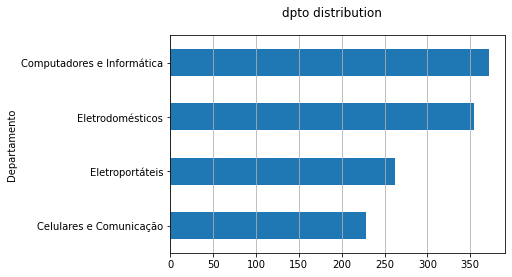

In [ ]:
# PT description PT pipeline product category distribution
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.suptitle('dpto distribution', fontsize=12)
data_pt_pt['Departamento'].reset_index().groupby('Departamento').count().sort_values(by=
'index').plot(kind='barh', legend=False, ax=ax).grid(axis='x')
plt.show()

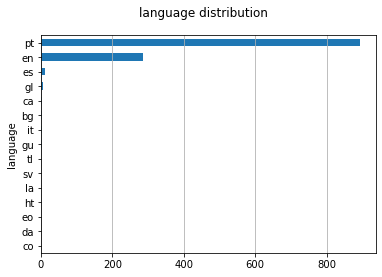

In [ ]:
# PT description PT language description category distribution
fig, ax = plt.subplots()
fig.suptitle('language distribution', fontsize=12)
data_pt_pt['language'].reset_index().groupby('language').count().sort_values(by=
'index').plot(kind='barh', legend=False, ax=ax).grid(axis='x')
plt.show()

# Modeling with Word Embedding vectors

## Set up

In [ ]:
from sklearn.model_selection import train_test_split

Since this is a 'one vs all' approach, defines target category and uses word embedding vectors as explanatory variables ('X').

In [ ]:
data_pt_pt_X = data_pt_pt.vec_pt_en.str[1:-1].str.split(expand=True).apply(pd.to_numeric)
data_pt_pt_y = pd.DataFrame(data_pt_pt['Departamento']).copy()

In [ ]:
data_pt_pt_y['Target'] = 0
data_pt_pt_y.loc[data_pt_pt_y['Departamento']=='Celulares e Comunicação','Target'] = 1
data_pt_pt_y = data_pt_pt_y.pop('Target')

In [ ]:
data_pt_pt_y

0       0
1       0
2       0
3       0
4       0
       ..
1211    1
1212    1
1213    1
1214    1
1215    1
Name: Target, Length: 1216, dtype: int64

In [ ]:
data_pt_pt_X

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.861880,-0.554172,-0.757331,1.379387,-0.712550,0.114787,-2.127228,-1.869729,-1.023301,0.004139,...,1.210903,-0.321954,-0.976725,-1.230470,0.950623,-0.777153,0.566295,-0.873077,-0.214928,0.490585
1,-1.066976,-0.996912,-3.238276,-0.150161,2.341870,2.301700,-0.923975,-1.887239,-1.741135,0.092268,...,0.685835,0.036380,-1.154664,-0.484291,-0.610318,-0.777929,0.182166,1.000631,-0.774751,0.387428
2,-0.999081,-1.496928,-1.502485,0.495169,0.793232,0.692351,-1.402536,-1.469971,-1.840008,0.227416,...,1.531721,-0.004975,-0.333605,-0.496175,-0.312577,-0.653219,0.368908,-0.370058,-0.829346,0.265934
3,0.008694,0.282899,-0.690904,1.166400,1.455887,-0.040001,-1.044143,0.079414,-0.462491,-0.948222,...,3.236859,-0.698301,0.321226,-1.360677,1.313164,-1.765027,0.317259,-0.537139,-0.485040,-0.173056
4,-1.851190,-1.447486,-1.519356,0.177390,0.540133,1.242671,-0.952926,-1.510099,-1.640919,-0.721394,...,2.015363,-0.741891,0.978950,-0.059314,-0.254616,-0.487540,0.282727,1.182821,-1.492929,0.624283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,0.267516,-0.980414,-0.456730,-0.594262,0.704767,0.779343,-1.599469,-1.179484,-2.548021,-1.326194,...,1.586757,-0.485357,0.921854,0.069619,0.064937,-1.306230,-0.854699,-0.309132,-1.112223,0.137376
1212,-0.615527,-2.133485,-1.516018,0.592276,-0.323934,0.437103,-1.809935,-1.549274,-0.483107,-0.264384,...,0.523023,0.322965,0.933195,-0.563601,-0.309898,-0.015770,-0.187480,-0.568887,-0.555995,0.600672
1213,-1.013467,-1.596467,-1.446473,1.462170,0.046208,0.881632,-1.385600,-1.447413,-0.929900,-1.462653,...,1.399503,0.108553,2.394163,-1.071317,-1.613517,-0.808823,-0.361850,0.823671,-2.819415,-0.333810
1214,-0.107195,-1.275162,-1.656871,0.882663,-0.480251,-0.187269,-1.654397,-1.675349,-1.286534,0.237862,...,1.167059,-0.038659,0.584105,0.211277,0.334094,0.031677,0.209259,-0.035837,-1.355243,0.533083


## Linear SVM

### Linear SVM on PT_PT with GridSearch optimization

In [ ]:
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Classifier
lin_svc = SVC(random_state=1, kernel='linear', max_iter=-1)

space = dict()
space['C'] = [0.1, 1, 10, 100]
space['gamma'] = [0.001, 0.01, 0.1, 1.0, 'scale']
search = GridSearchCV(lin_svc, space, scoring='f1', n_jobs=-1, cv=cv)

In [ ]:
st = time.time()
result = search.fit(data_pt_pt_X,data_pt_pt_y)
ed = time.time()
print(ed-st)

42.611929416656494


In [ ]:
print("Best Score: {:.4f}".format(result.best_score_))
print("Best Hyperparameters: {}".format(str(result.best_params_)))

Best Score: 0.7259
Best Hyperparameters: {'C': 0.1, 'gamma': 0.001}


In [ ]:
pt_pt_linSVC = SVC(random_state=1
                       ,kernel='linear'
                       ,max_iter=-1
                       ,C=0.1
                       ,gamma=0.001
                  )                                          

In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_validate

In [ ]:
scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1'}

In [ ]:
pt_pt_linSVC_scores = pd.DataFrame(cross_validate(pt_pt_linSVC, data_pt_pt_X, data_pt_pt_y, 
                        scoring=scoring, cv=cv))

### Linear SVM PT_PT Results

In [ ]:
pt_pt_linSVC_scores.mean()

fit_time          0.136125
score_time        0.015624
test_accuracy     0.897755
test_precision    0.732242
test_recall       0.725560
test_f1           0.725912
dtype: float64

### Linear SVM On EN_EN with GridSearch optimization

In [ ]:
data_en_en_X = data_en_en.vec_en_en.str[1:-1].str.split(expand=True).apply(pd.to_numeric)
data_en_en_y = pd.DataFrame(data_en_en['Departamento']).copy()

In [ ]:
data_en_en_y['Target'] = 0
data_en_en_y.loc[data_en_en_y['Departamento']=='Celulares e Comunicação','Target'] = 1
data_en_en_y = data_en_en_y.pop('Target')

In [ ]:
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Classifier
lin_svc = SVC(random_state=1, kernel='linear', max_iter=-1)

space = dict()
space['C'] = [0.1, 1, 10, 100]
space['gamma'] = [0.001, 0.01, 0.1, 1.0, 'scale']
search = GridSearchCV(lin_svc, space, scoring='f1', n_jobs=-1, cv=cv)

In [ ]:
st = time.time()


result = search.fit(data_en_en_X,data_en_en_y)

ed = time.time()
print(ed-st)

21.522153854370117


In [ ]:
print("Best Score: {:.4f}".format(result.best_score_))
print("Best Hyperparameters: {}".format(str(result.best_params_)))

Best Score: 0.8924
Best Hyperparameters: {'C': 0.1, 'gamma': 0.001}


In [ ]:
en_en_linSVC = SVC(random_state=1
                       ,kernel='linear'
                       ,max_iter=-1
                       ,C=0.1
                       ,gamma=0.001
                  )                                          

In [ ]:
en_en_linSVC_scores = pd.DataFrame(cross_validate(en_en_linSVC, data_en_en_X, data_en_en_y, 
                        scoring=scoring, cv=cv))

### Linear SVM EN_EN Results

In [ ]:
en_en_linSVC_scores.mean()

fit_time          0.116028
score_time        0.016126
test_accuracy     0.947103
test_precision    0.926751
test_recall       0.863172
test_f1           0.892391
dtype: float64

## Non-linear SVM

### Non-linear SVM On PT_PT with GridSearch optimization

In [ ]:
# Classifier
non_lin_svc = SVC(random_state=1, max_iter=-1)

space = dict()
space['C'] = [0.1, 1, 10, 100]
space['kernel'] = ['rbf','poly','sigmoid']
space['gamma'] = [0.001, 0.01, 0.1, 1.0, 'scale']
search = GridSearchCV(non_lin_svc, space, scoring='f1', n_jobs=-1, cv=cv)

In [ ]:
st = time.time()
result = search.fit(data_pt_pt_X,data_pt_pt_y)
ed = time.time()
print(ed-st)

2774.477659225464


In [ ]:
print("Best Score: {:.4f}".format(result.best_score_))
print("Best Hyperparameters: {}".format(str(result.best_params_)))

Best Score: 0.7569
Best Hyperparameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
pt_pt_nonlinSVC = SVC(random_state=1
                       ,kernel='rbf'
                       ,max_iter=-1
                       ,C=10
                       ,gamma=0.001
                  )                                          

In [ ]:
pt_pt_nonlinSVC_scores = pd.DataFrame(cross_validate(pt_pt_nonlinSVC, data_pt_pt_X, data_pt_pt_y, 
                        scoring=scoring, cv=cv))

### Non-Linear SVM PT_PT results

In [ ]:
pt_pt_nonlinSVC_scores.mean()

fit_time          0.144434
score_time        0.018787
test_accuracy     0.910109
test_precision    0.770972
test_recall       0.748814
test_f1           0.756850
dtype: float64

### Non-linear SVM EN_EN with GridSearch optimization

In [ ]:
# Classifier
non_lin_svc = SVC(random_state=1, max_iter=-1)

space = dict()
space['C'] = [0.1, 1, 10, 100]
space['kernel'] = ['rbf','poly','sigmoid']
space['gamma'] = [0.001, 0.01, 0.1, 1.0, 'scale']
search = GridSearchCV(non_lin_svc, space, scoring='f1', n_jobs=-1, cv=cv)

In [ ]:
st = time.time()
result = search.fit(data_en_en_X,data_en_en_y)
ed = time.time()
print(ed-st)

125.66147327423096


In [ ]:
print("Best Score: {:.4f}".format(result.best_score_))
print("Best Hyperparameters: {}".format(str(result.best_params_)))

Best Score: 0.9069
Best Hyperparameters: {'C': 0.1, 'gamma': 1.0, 'kernel': 'poly'}


In [ ]:
en_en_nonlinSVC = SVC(random_state=1
                       ,kernel='poly'
                       ,max_iter=-1
                       ,C=0.1
                       ,gamma=1.0
                  )                                          

In [ ]:
en_en_nonlinSVC_scores = pd.DataFrame(cross_validate(en_en_nonlinSVC, data_en_en_X, data_en_en_y, 
                        scoring=scoring, cv=cv))

### Non-Linear SVM EN_EN Results

In [ ]:
en_en_nonlinSVC_scores.mean()

fit_time          0.122772
score_time        0.016625
test_accuracy     0.953407
test_precision    0.927449
test_recall       0.890020
test_f1           0.906942
dtype: float64

## Random Forest

### Random Forest PT PT with GridSearch optimization

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Classifier
rand_for = RandomForestClassifier(random_state=1)

space = dict()
space['n_estimators'] = [50,100,500]
space['max_features'] = ['auto','sqrt']
space['max_depth'] = [10,50]
space['min_samples_split'] = [2,5,10]
space['min_samples_leaf'] = [1,4]
space['bootstrap'] = [True,False]

search = GridSearchCV(rand_for, space, scoring='f1', n_jobs=-1, cv=cv)

In [ ]:
st = time.time()
result = search.fit(data_pt_pt_X,data_pt_pt_y)
ed = time.time()
print(ed-st)

4003.0033934116364


In [ ]:
print("Best Score: {:.4f}".format(result.best_score_))
print("Best Hyperparameters: {}".format(str(result.best_params_)))

Best Score: 0.6468
Best Hyperparameters: {'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
pt_pt_rand_for = RandomForestClassifier(random_state=1
                                        ,n_estimators = 100
                                        ,max_features = 'auto'
                                        ,max_depth = 50
                                        ,min_samples_split = 2
                                        ,min_samples_leaf = 1
                                        ,bootstrap = False
                  )                                          

In [ ]:
pt_pt_rand_for_scores = pd.DataFrame(cross_validate(pt_pt_rand_for, data_pt_pt_X, data_pt_pt_y, 
                        scoring=scoring, cv=cv))

### Random Forest PT_PT Results

In [ ]:
pt_pt_rand_for_scores.mean()

fit_time          1.188330
score_time        0.014776
test_accuracy     0.890889
test_precision    0.829140
test_recall       0.538340
test_f1           0.646795
dtype: float64

### Random Forest EN_EN with GridSearch optimization

In [ ]:
# Classifier
rand_for = RandomForestClassifier(random_state=1)

space = dict()
space['n_estimators'] = [50,100,500]
space['max_features'] = ['auto','sqrt']
space['max_depth'] = [10,50]
space['min_samples_split'] = [2,5,10]
space['min_samples_leaf'] = [1,4]
space['bootstrap'] = [True,False]

search = GridSearchCV(rand_for, space, scoring='f1', n_jobs=-1, cv=cv)

In [ ]:
st = time.time()
result = search.fit(data_en_en_X,data_en_en_y)
ed = time.time()
print(ed-st)

4269.133909225464


In [ ]:
print("Best Score: {:.4f}".format(result.best_score_))
print("Best Hyperparameters: {}".format(str(result.best_params_)))

Best Score: 0.8674
Best Hyperparameters: {'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [ ]:
en_en_rand_for = RandomForestClassifier(random_state=1
                                        ,n_estimators = 500
                                        ,max_features = 'auto'
                                        ,max_depth = 50
                                        ,min_samples_split = 2
                                        ,min_samples_leaf = 1
                                        ,bootstrap = False
                  )                                          

In [ ]:
en_en_rand_for_scores = pd.DataFrame(cross_validate(en_en_rand_for, data_en_en_X, data_en_en_y, 
                        scoring=scoring, cv=cv))

### Random Forest EN_EN Results

In [ ]:
en_en_rand_for_scores.mean()

fit_time          6.235088
score_time        0.052019
test_accuracy     0.937520
test_precision    0.946513
test_recall       0.803595
test_f1           0.867358
dtype: float64

## XGBoost

### XGBoost PT_PT with GridSearch optimization

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
} 


grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(data_pt_pt_X, data_pt_pt_y)

In [ ]:
grid_search.best_estimator_
print("Best Score: {:.4f}".format(grid_search.best_score_))
print("Best Hyperparameters: {}".format(str(grid_search.best_params_)))

Best Score: 0.9290
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 180}


In [ ]:
pt_pt_xgboost = XGBClassifier(
                    objective= 'binary:logistic'
                    ,nthread=4
                    ,seed=42
                    ,learning_rate = 0.01
                    ,max_depth = 2
                    ,n_estimators = 180
)                               

In [ ]:
pt_pt_xgboost_scores = pd.DataFrame(cross_validate(pt_pt_xgboost, data_pt_pt_X, data_pt_pt_y, 
                        scoring=scoring, cv=cv))

C:\Users\conno\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:46:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:46:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:46:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\conno\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:46:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:46:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:46:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\conno\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

### XGBoost PT_PT Results

In [ ]:
pt_pt_xgboost_scores.mean()

fit_time          2.716526
score_time        0.011271
test_accuracy     0.852547
test_precision    0.752928
test_recall       0.323254
test_f1           0.447663
dtype: float64

### XG Boost EN_EN with GridSearch optimization

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
} 


grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(data_en_en_X, data_en_en_y)


Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   27.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  5.1min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 13.3min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 30.1min
[Parallel(n_jobs=10)]: Done 960 out of 960 | elapsed: 37.9min finished
C:\Users\conno\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=No

In [ ]:
grid_search.best_estimator_
print("Best Score: {:.4f}".format(grid_search.best_score_))
print("Best Hyperparameters: {}".format(str(grid_search.best_params_)))

Best Score: 0.8726
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 180}


In [ ]:
en_en_xgboost = XGBClassifier(
                    objective= 'binary:logistic'
                    ,nthread=4
                    ,seed=42
                    ,learning_rate = 0.1
                    ,max_depth = 2
                    ,n_estimators = 180
)                               

In [ ]:
en_en_xgboost_scores = pd.DataFrame(cross_validate(en_en_xgboost, data_en_en_X, data_en_en_y, 
                        scoring=scoring, cv=cv))

C:\Users\conno\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\conno\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:48:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:48:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:48:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:48:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\conno\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:48:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:48:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:48:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:48:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

### XGBoost EN_EN Results

In [ ]:
en_en_xgboost_scores.mean()

fit_time          2.189064
score_time        0.008677
test_accuracy     0.942718
test_precision    0.913062
test_recall       0.861156
test_f1           0.884844
dtype: float64

# Modeling with TF-IDF vectors

## Set up

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Transformação com TF-IDF
vectorizer = TfidfVectorizer()

### PT_PT TF IDF Vectorization

In [ ]:
X_pt_pt = data_pt_pt['text_lem_en']

In [ ]:
X_tfidf_pt_pt = vectorizer.fit_transform(X_pt_pt.astype(str))

In [ ]:
X_tfidf_pt_pt = pd.DataFrame(X_tfidf_pt_pt.toarray(), columns=vectorizer.get_feature_names()) 

### EN_EN TF IDF Vectorization

In [ ]:
X_en_en = data_en_en['text_lem_en']

In [ ]:
X_tfidf_en_en = vectorizer.fit_transform(X_en_en.astype(str))

In [ ]:
X_tfidf_en_en = pd.DataFrame(X_tfidf_en_en.toarray(), columns=vectorizer.get_feature_names()) 

## Linear SVM

### Linear SVM PT_PT with GridSearch

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Classifier
lin_svc = SVC(random_state=1, kernel='linear', max_iter=-1)

space = dict()
space['C'] = [0.1, 1, 10, 100]
space['gamma'] = [0.001, 0.01, 0.1, 1.0, 'scale']
search = GridSearchCV(lin_svc, space, scoring='f1', n_jobs=-1, cv=cv)

In [ ]:
st = time.time()
#

result = search.fit(X_tfidf_pt_pt,data_pt_pt_y)

ed = time.time()
print(ed-st)

220.0675172805786


In [ ]:
print("Best Score: {:.4f}".format(result.best_score_))
print("Best Hyperparameters: {}".format(str(result.best_params_)))

Best Score: 0.7690
Best Hyperparameters: {'C': 1, 'gamma': 0.001}


In [ ]:
pt_pt_tfidf_linSVC = SVC(random_state=1
                       ,kernel='linear'
                       ,max_iter=-1
                       ,C=1
                       ,gamma=0.001
                  )                                          

In [ ]:
pt_pt_tfidf_linSVC_scores = pd.DataFrame(cross_validate(pt_pt_tfidf_linSVC, X_tfidf_pt_pt, data_pt_pt_y, 
                        scoring=scoring, cv=cv))

### Linear SVM PT_PT results

In [ ]:
pt_pt_tfidf_linSVC_scores.mean()

fit_time          1.173187
score_time        0.133463
test_accuracy     0.917787
test_precision    0.814629
test_recall       0.735771
test_f1           0.769049
dtype: float64

### Linear SVM EN_EN with GridSearch

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Classifier
lin_svc = SVC(random_state=1, kernel='linear', max_iter=-1)

space = dict()
space['C'] = [0.1, 1, 10, 100]
space['gamma'] = [0.001, 0.01, 0.1, 1.0, 'scale']
search = GridSearchCV(lin_svc, space, scoring='f1', n_jobs=-1, cv=cv)

In [ ]:
st = time.time()
result = search.fit(X_tfidf_en_en,data_en_en_y)
ed = time.time()
print(ed-st)

216.41340923309326


In [ ]:
print("Best Score: {:.4f}".format(result.best_score_))
print("Best Hyperparameters: {}".format(str(result.best_params_)))

Best Score: 0.9004
Best Hyperparameters: {'C': 10, 'gamma': 0.001}


In [ ]:
en_en_tfidf_linSVC = SVC(random_state=1
                       ,kernel='linear'
                       ,max_iter=-1
                       ,C=10
                       ,gamma=0.001
                  )                                          

In [ ]:
en_en_tfidf_linSVC_scores = pd.DataFrame(cross_validate(en_en_tfidf_linSVC, X_tfidf_en_en, data_en_en_y, 
                        scoring=scoring, cv=cv))

### Linear SVM PT_PT Results

In [ ]:
en_en_tfidf_linSVC_scores.mean()

fit_time          0.847123
score_time        0.094512
test_accuracy     0.950673
test_precision    0.934621
test_recall       0.870968
test_f1           0.900421
dtype: float64

## Non-Linear SVM

### Non-Linear SVM PT_PT with GridSearch

In [ ]:
# Classifier
non_lin_svc = SVC(random_state=1, max_iter=-1)

space = dict()
space['C'] = [0.1, 1, 10, 100]
space['kernel'] = ['rbf','poly','sigmoid']
space['gamma'] = [0.001, 0.01, 0.1, 1.0, 'scale']
search = GridSearchCV(non_lin_svc, space, scoring='f1', n_jobs=-1, cv=cv)

In [ ]:
st = time.time()
print(st)
result = search.fit(X_tfidf_pt_pt,data_pt_pt_y)
ed = time.time()
print(ed-st)

1627502479.3177948
1032.994833946228


In [ ]:
print("Best Score: {:.4f}".format(result.best_score_))
print("Best Hyperparameters: {}".format(str(result.best_params_)))

Best Score: 0.7723
Best Hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
pt_pt_tfidf_nonlinSVC = SVC(random_state=1
                       ,kernel='rbf'
                       ,max_iter=-1
                       ,C=10
                       ,gamma=0.01
                  )                                          

In [ ]:
pt_pt_tfidf_nonlinSVC_scores = pd.DataFrame(cross_validate(pt_pt_tfidf_nonlinSVC, X_tfidf_pt_pt, data_pt_pt_y, 
                        scoring=scoring, cv=cv))

### Non-Linear SVM PT_PT Results

In [ ]:
pt_pt_tfidf_nonlinSVC_scores.mean()

fit_time          1.380973
score_time        0.159954
test_accuracy     0.867340
test_precision    0.847667
test_recall       0.359750
test_f1           0.500157
dtype: float64

### Non-Linear SVM EN_EN with GridSearch

In [ ]:
# Classifier
non_lin_svc = SVC(random_state=1, max_iter=-1)

space = dict()
space['C'] = [0.1, 1, 10, 100]
space['kernel'] = ['rbf','poly','sigmoid']
space['gamma'] = [0.001, 0.01, 0.1, 1.0, 'scale']
search = GridSearchCV(non_lin_svc, space, scoring='f1', n_jobs=-1, cv=cv)

In [ ]:
st = time.time()
print(st)
result = search.fit(X_tfidf_en_en,data_en_en_y)
ed = time.time()
print(ed-st)

1627503512.3594565
1097.7213854789734


In [ ]:
print("Best Score: {:.4f}".format(result.best_score_))
print("Best Hyperparameters: {}".format(str(result.best_params_)))

Best Score: 0.9029
Best Hyperparameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
en_en_tfidf_nonlinSVC = SVC(random_state=1
                       ,kernel='rbf'
                       ,max_iter=-1
                       ,C=100
                       ,gamma=0.1
                  )                                          

In [ ]:
en_en_tfidf_nonlinSVC_scores = pd.DataFrame(cross_validate(en_en_tfidf_nonlinSVC, X_tfidf_en_en, data_en_en_y, 
                        scoring=scoring, cv=cv))

### Non-Linear SVM EN_EN Results

In [ ]:
en_en_tfidf_nonlinSVC_scores.mean()

fit_time          1.002622
score_time        0.115709
test_accuracy     0.952048
test_precision    0.939870
test_recall       0.870968
test_f1           0.902926
dtype: float64

## Random Forest

### Random Forest PT_PT with GridSearch

In [ ]:
# Classifier
rand_for = RandomForestClassifier(random_state=1)

# Only tune for estimators used in other two models
space = dict()
space['n_estimators'] = [100,500]
space['max_features'] = ['auto']
space['max_depth'] = [50]
space['min_samples_split'] = [2]
space['min_samples_leaf'] = [1]
space['bootstrap'] = [False]

search = GridSearchCV(rand_for, space, scoring='f1', n_jobs=-1, cv=cv)

In [ ]:
st = time.time()
result = search.fit(X_tfidf_pt_pt,data_pt_pt_y)
ed = time.time()
print(ed-st)

245.66014981269836


In [ ]:
print("Best Score: {:.4f}".format(result.best_score_))
print("Best Hyperparameters: {}".format(str(result.best_params_)))

Best Score: 0.7730
Best Hyperparameters: {'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
pt_pt_tfidf_rand_for = RandomForestClassifier(random_state=1
                                        ,n_estimators = 100
                                        ,max_features = 'auto'
                                        ,max_depth = 50
                                        ,min_samples_split = 2
                                        ,min_samples_leaf = 1
                                        ,bootstrap = False
                  )                                          

In [ ]:
pt_pt_tfidf_rand_for_scores = pd.DataFrame(cross_validate(pt_pt_tfidf_rand_for, X_tfidf_pt_pt, data_pt_pt_y, 
                        scoring=scoring, cv=cv))

### Random Forest PT_PT Results

In [ ]:
pt_pt_tfidf_rand_for_scores.mean()

fit_time          2.128339
score_time        0.025385
test_accuracy     0.920774
test_precision    0.835078
test_recall       0.725362
test_f1           0.773033
dtype: float64

### Random Forest EN_EN with GridSearch

In [ ]:
# Classifier
rand_for = RandomForestClassifier(random_state=1)

# Only tune for estimators used in other two models
space = dict()
space['n_estimators'] = [100,500]
space['max_features'] = ['auto']
space['max_depth'] = [50]
space['min_samples_split'] = [2]
space['min_samples_leaf'] = [1]
space['bootstrap'] = [False]

search = GridSearchCV(rand_for, space, scoring='f1', n_jobs=-1, cv=cv)

In [ ]:
st = time.time()
result = search.fit(X_tfidf_en_en,data_en_en_y)
ed = time.time()
print(ed-st)

225.3010914325714


In [ ]:
print("Best Score: {:.4f}".format(result.best_score_))
print("Best Hyperparameters: {}".format(str(result.best_params_)))

Best Score: 0.8888
Best Hyperparameters: {'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [ ]:
en_en_tfidf_rand_for = RandomForestClassifier(random_state=1
                                        ,n_estimators = 500
                                        ,max_features = 'auto'
                                        ,max_depth = 50
                                        ,min_samples_split = 2
                                        ,min_samples_leaf = 1
                                        ,bootstrap = False
                  )                                          

In [ ]:
en_en_tfidf_rand_for_scores = pd.DataFrame(cross_validate(en_en_tfidf_rand_for, X_tfidf_en_en, data_en_en_y, 
                        scoring=scoring, cv=cv))

### Random Forest EN_EN Results

In [ ]:
en_en_tfidf_rand_for_scores.mean()

fit_time          8.048642
score_time        0.062084
test_accuracy     0.945737
test_precision    0.934671
test_recall       0.850437
test_f1           0.888790
dtype: float64

## XGBoost

### XGBoost PT_PT with GridSearch

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': [2],
    'n_estimators': [180],
    'learning_rate': [0.1,0.01]
} 


grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(X_tfidf_pt_pt, data_pt_pt_y)


Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:   53.1s finished
C:\Users\conno\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=No

In [ ]:
grid_search.best_estimator_
print("Best Score: {:.4f}".format(grid_search.best_score_))
print("Best Hyperparameters: {}".format(str(grid_search.best_params_)))

Best Score: 0.6608
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 180}


In [ ]:
pt_pt_tfidf_xgboost = XGBClassifier(
                    objective= 'binary:logistic'
                    ,nthread=4
                    ,seed=42
                    ,learning_rate = 0.1
                    ,max_depth = 2
                    ,n_estimators = 180
)                               

In [ ]:
pt_pt_tfidf_xgboost_scores = pd.DataFrame(cross_validate(pt_pt_tfidf_xgboost, X_tfidf_pt_pt, data_en_en_y, 
                        scoring=scoring, cv=cv))

C:\Users\conno\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\conno\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\conno\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

### XGBoost PT_PT with Results

In [ ]:
pt_pt_tfidf_xgboost_scores.mean()

fit_time          2.286001
score_time        0.008943
test_accuracy     0.944077
test_precision    0.968398
test_recall       0.809778
test_f1           0.880289
dtype: float64

### XGBoost EN_EN with GridSearch

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': [2],
    'n_estimators': [180],
    'learning_rate': [0.1,0.01]
} 


grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(X_tfidf_en_en, data_en_en_y)


Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:   37.9s finished
C:\Users\conno\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:45:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=No

In [ ]:
grid_search.best_estimator_
print("Best Score: {:.4f}".format(grid_search.best_score_))
print("Best Hyperparameters: {}".format(str(grid_search.best_params_)))

Best Score: 0.8533
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 180}


In [ ]:
en_en_tfidf_xgboost = XGBClassifier(
                    objective= 'binary:logistic'
                    ,nthread=4
                    ,seed=42
                    ,learning_rate = 0.1
                    ,max_depth = 2
                    ,n_estimators = 180
)                               

In [ ]:
en_en_tfidf_xgboost_scores = pd.DataFrame(cross_validate(en_en_tfidf_xgboost, X_tfidf_en_en, data_en_en_y, 
                        scoring=scoring, cv=cv))

C:\Users\conno\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\conno\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\conno\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

### XGBoost EN_EN Results

In [ ]:
en_en_tfidf_xgboost_scores.mean()

fit_time          2.796324
score_time        0.011403
test_accuracy     0.938872
test_precision    0.954585
test_recall       0.801378
test_f1           0.869458
dtype: float64

# Results for All Models

In [ ]:
# Add a column with the score type and concatenate the tables

In [ ]:
pt_pt_linSVC_scores['dataset'] = 'pt_pt' 
en_en_linSVC_scores['dataset'] = 'en_en'

pt_pt_nonlinSVC_scores['dataset'] = 'pt_pt'
en_en_nonlinSVC_scores['dataset'] = 'en_en'

pt_pt_rand_for_scores['dataset'] = 'pt_pt'
en_en_rand_for_scores['dataset'] = 'en_en'

pt_pt_xgboost_scores['dataset'] = 'pt_pt'
en_en_xgboost_scores['dataset'] = 'en_en'

pt_pt_tfidf_linSVC_scores['dataset'] = 'pt_pt'
en_en_tfidf_linSVC_scores['dataset'] = 'en_en'

pt_pt_tfidf_nonlinSVC_scores['dataset'] = 'pt_pt'
en_en_tfidf_nonlinSVC_scores['dataset'] = 'en_en'

pt_pt_tfidf_rand_for_scores['dataset'] = 'pt_pt'
en_en_tfidf_rand_for_scores['dataset'] = 'en_en'

pt_pt_tfidf_xgboost_scores['dataset'] = 'pt_pt'
en_en_tfidf_xgboost_scores['dataset'] = 'en_en'

In [ ]:
pt_pt_linSVC_scores['vect'] = 'wemb' 
en_en_linSVC_scores['vect'] = 'wemb'

pt_pt_nonlinSVC_scores['vect'] = 'wemb'
en_en_nonlinSVC_scores['vect'] = 'wemb'

pt_pt_rand_for_scores['vect'] = 'wemb'
en_en_rand_for_scores['vect'] = 'wemb'

pt_pt_xgboost_scores['vect'] = 'wemb'
en_en_xgboost_scores['vect'] = 'wemb'

pt_pt_tfidf_linSVC_scores['vect'] = 'tfidf'
en_en_tfidf_linSVC_scores['vect'] = 'tfidf'

pt_pt_tfidf_nonlinSVC_scores['vect'] = 'tfidf'
en_en_tfidf_nonlinSVC_scores['vect'] = 'tfidf'

pt_pt_tfidf_rand_for_scores['vect'] = 'tfidf'
en_en_tfidf_rand_for_scores['vect'] = 'tfidf'

pt_pt_tfidf_xgboost_scores['vect'] = 'tfidf'
en_en_tfidf_xgboost_scores['vect'] = 'tfidf'

In [ ]:
pt_pt_linSVC_scores['model'] = 'linsvc' 
en_en_linSVC_scores['model'] = 'linsvc'

pt_pt_nonlinSVC_scores['model'] = 'nonlinsvc'
en_en_nonlinSVC_scores['model'] = 'nonlinsvc'

pt_pt_rand_for_scores['model'] = 'randfor'
en_en_rand_for_scores['model'] = 'randfor'

pt_pt_xgboost_scores['model'] = 'xgboost'
en_en_xgboost_scores['model'] = 'xgboost'

pt_pt_tfidf_linSVC_scores['model'] = 'linsvc'
en_en_tfidf_linSVC_scores['model'] = 'linsvc'

pt_pt_tfidf_nonlinSVC_scores['model'] = 'nonlinsvc'
en_en_tfidf_nonlinSVC_scores['model'] = 'nonlinsvc'

pt_pt_tfidf_rand_for_scores['model'] = 'randfor'
en_en_tfidf_rand_for_scores['model'] = 'randfor'

pt_pt_tfidf_xgboost_scores['model'] = 'xgboost'
en_en_tfidf_xgboost_scores['model'] = 'xgboost'

In [ ]:
pt_pt_linSVC_scores['unique'] = 'pt_pt_wemb_linsvc' 
en_en_linSVC_scores['unique'] = 'en_en_wemb_linsvc'

pt_pt_nonlinSVC_scores['unique'] = 'pt_pt_wemb_nonlinsvc'
en_en_nonlinSVC_scores['unique'] = 'en_en_wemb_nonlinsvc'

pt_pt_rand_for_scores['unique'] = 'pt_pt_wemb_randfor'
en_en_rand_for_scores['unique'] = 'en_en_wemb_randfor'

pt_pt_xgboost_scores['unique'] = 'pt_pt_wemb_xgboost'
en_en_xgboost_scores['unique'] = 'en_en_wemb_xgboost'

pt_pt_tfidf_linSVC_scores['unique'] = 'pt_pt_tfidf_linsvc'
en_en_tfidf_linSVC_scores['unique'] = 'en_en_tfidf_linsvc'

pt_pt_tfidf_nonlinSVC_scores['unique'] = 'pt_pt_tfidf_nonlinsvc'
en_en_tfidf_nonlinSVC_scores['unique'] = 'en_en_tfidf_nonlinsvc'

pt_pt_tfidf_rand_for_scores['unique'] = 'pt_pt_tfidf_randfor'
en_en_tfidf_rand_for_scores['unique'] = 'en_en_tfidf_randfor'

pt_pt_tfidf_xgboost_scores['unique'] = 'pt_pt_tfidf_xgboost'
en_en_tfidf_xgboost_scores['unique'] = 'en_en_tfidf_xgboost'

In [ ]:
all_scores = pd.concat([
                pt_pt_linSVC_scores
                ,en_en_linSVC_scores
                ,pt_pt_nonlinSVC_scores
                ,en_en_nonlinSVC_scores
                ,pt_pt_rand_for_scores
                ,en_en_rand_for_scores
                ,pt_pt_xgboost_scores
                ,en_en_xgboost_scores
                ,pt_pt_tfidf_linSVC_scores
                ,en_en_tfidf_linSVC_scores
                ,pt_pt_tfidf_nonlinSVC_scores
                ,en_en_tfidf_nonlinSVC_scores
                ,pt_pt_tfidf_rand_for_scores
                ,en_en_tfidf_rand_for_scores
                ,pt_pt_tfidf_xgboost_scores
                ,en_en_tfidf_xgboost_scores
])

In [ ]:
all_scores.to_csv('dat/all_scores_dat.csv')
all_scores.to_excel('dat/all_scores_dat.xlsx')

<AxesSubplot:title={'center':'Accuracy'}, xlabel='Treatment', ylabel='Accuracy %'>

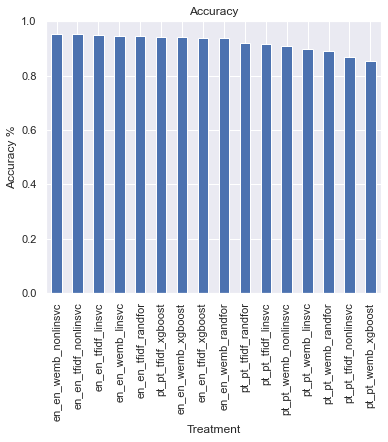

In [ ]:
# Metrics
# test_accuracy
# test_precision
# test_recall
# test_f1

asg = all_scores.groupby(['unique'])['test_accuracy'].mean().sort_values(ascending=False)
asg_df = pd.DataFrame(asg)

asg.plot(kind='bar', title='Accuracy', ylabel='Accuracy %',
         xlabel='Treatment', figsize=(6, 5))

The plot above shows ordered from the best to the worst accuracy scores for all 16 possible combinations of models x corpus x vectorization methods.

We can notice that the combination that produced the best result is **Non-Linear SVM applied to word embedding numerical vectors obtained from translated descriptions submited to 'english NLP pipeline'**.

On the other hand there's the **XGBoost applied to word embedding numerical vectors obtained from portuguese descriptions submited to 'portuguese NLP pipeline'** with the worst results.

## Metrics

### The score table has been summarized in this chart.
https://docs.google.com/spreadsheets/d/1bSuN1ZnMzUKVk0kVGV06AaWKgegCFDZoc3BqkMuuXEw/edit?usp=sharing

# AUC ROC Curve

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [ ]:
# Earlier, CV was used to train and score the models
# For ROC, we have used a simple Train/Test split of 80/20
pt_pt_wemb_X_train, pt_pt_wemb_X_test, pt_pt_wemb_y_train, pt_pt_wemb_y_test = train_test_split(data_pt_pt_X,data_pt_pt_y, test_size=0.2, random_state=1)
en_en_wemb_X_train, en_en_wemb_X_test, en_en_wemb_y_train, en_en_wemb_y_test = train_test_split(data_en_en_X,data_en_en_y, test_size=0.2, random_state=1)
pt_pt_tfidf_X_train, pt_pt_tfidf_X_test, pt_pt_tfidf_y_train, pt_pt_tfidf_y_test = train_test_split(X_tfidf_pt_pt,data_pt_pt_y, test_size=0.2, random_state=1)
en_en_tfidf_X_train, en_en_tfidf_X_test, en_en_tfidf_y_train, en_en_tfidf_y_test = train_test_split(X_tfidf_en_en,data_en_en_y, test_size=0.2, random_state=1)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

## Probability Scores

In [ ]:
# Generate probability scores for each model
# Refit the models to create probability scores

## SVM Linear Model

### PT_PT

In [ ]:
# WEMB
pt_pt_wemb_linsvc_prob = SVC(random_state=1
                       ,kernel='linear'
                       ,max_iter=-1
                       ,C=0.1
                       ,gamma=0.001
                       ,probability=True                                 
                  )
pt_pt_wemb_linsvc_prob.fit(pt_pt_wemb_X_train, pt_pt_wemb_y_train)
pt_pt_wemb_linsvc_probscores = pt_pt_wemb_linsvc_prob.predict_proba(pt_pt_wemb_X_test)[:,1]

# TFIDF
pt_pt_tfidf_linsvc_prob = SVC(random_state=1
                       ,kernel='linear'
                       ,max_iter=-1
                       ,C=1
                       ,gamma=0.001
                       ,probability=True                                 
                  )
pt_pt_tfidf_linsvc_prob.fit(pt_pt_tfidf_X_train, pt_pt_tfidf_y_train)
pt_pt_tfidf_linsvc_probscores = pt_pt_tfidf_linsvc_prob.predict_proba(pt_pt_tfidf_X_test)[:,1]

### EN_EN

In [ ]:
# WEMB
en_en_wemb_linsvc_prob = SVC(random_state=1
                       ,kernel='linear'
                       ,max_iter=-1
                       ,C=0.1
                       ,gamma=0.001
                       ,probability=True                                 
                  )
en_en_wemb_linsvc_prob.fit(en_en_wemb_X_train, en_en_wemb_y_train)
en_en_wemb_linsvc_probscores = en_en_wemb_linsvc_prob.predict_proba(en_en_wemb_X_test)[:,1]

# TFIDF
en_en_tfidf_linsvc_prob = SVC(random_state=1
                       ,kernel='linear'
                       ,max_iter=-1
                       ,C=10
                       ,gamma=0.001
                       ,probability=True                                 
                  )
en_en_tfidf_linsvc_prob.fit(en_en_tfidf_X_train, en_en_tfidf_y_train)
en_en_tfidf_linsvc_probscores = en_en_tfidf_linsvc_prob.predict_proba(en_en_tfidf_X_test)[:,1]

## SVM Non-Linear Model

### PT_PT

In [ ]:
# WEMB
pt_pt_wemb_nonlinsvc_prob = SVC(random_state=1
                       ,kernel='rbf'
                       ,max_iter=-1
                       ,C=10
                       ,gamma=0.001
                       ,probability=True                                 
                  )
pt_pt_wemb_nonlinsvc_prob.fit(pt_pt_wemb_X_train, pt_pt_wemb_y_train)
pt_pt_wemb_nonlinsvc_probscores = pt_pt_wemb_nonlinsvc_prob.predict_proba(pt_pt_wemb_X_test)[:,1]

# TFIDF
pt_pt_tfidf_nonlinsvc_prob = SVC(random_state=1
                       ,kernel='rbf'
                       ,max_iter=-1
                       ,C=10
                       ,gamma=0.01
                       ,probability=True                                 
                  )
pt_pt_tfidf_nonlinsvc_prob.fit(pt_pt_tfidf_X_train, pt_pt_tfidf_y_train)
pt_pt_tfidf_nonlinsvc_probscores = pt_pt_tfidf_nonlinsvc_prob.predict_proba(pt_pt_tfidf_X_test)[:,1]

### EN_EN

In [ ]:
# WEMB
en_en_wemb_nonlinsvc_prob = SVC(random_state=1
                       ,kernel='poly'
                       ,max_iter=-1
                       ,C=0.1
                       ,gamma=1.0
                       ,probability=True                                 
                  )
en_en_wemb_nonlinsvc_prob.fit(en_en_wemb_X_train, en_en_wemb_y_train)
en_en_wemb_nonlinsvc_probscores = en_en_wemb_nonlinsvc_prob.predict_proba(en_en_wemb_X_test)[:,1]

# TFIDF
en_en_tfidf_nonlinsvc_prob = SVC(random_state=1
                       ,kernel='rbf'
                       ,max_iter=-1
                       ,C=100
                       ,gamma=0.1
                       ,probability=True                                 
                  )
en_en_tfidf_nonlinsvc_prob.fit(en_en_tfidf_X_train, en_en_tfidf_y_train)
en_en_tfidf_nonlinsvc_probscores = en_en_tfidf_nonlinsvc_prob.predict_proba(en_en_tfidf_X_test)[:,1]

## Random Forest

In [ ]:
# Random forests can already predict proba - do not need probability argument

### PT_PT

In [ ]:
# WEMB
pt_pt_wemb_randfor_prob = RandomForestClassifier(random_state=1
                                        ,n_estimators = 100
                                        ,max_features = 'auto'
                                        ,max_depth = 50
                                        ,min_samples_split = 2
                                        ,min_samples_leaf = 1
                                        ,bootstrap = False
                  )      
pt_pt_wemb_randfor_prob.fit(pt_pt_wemb_X_train, pt_pt_wemb_y_train)
pt_pt_wemb_randfor_probscores = pt_pt_wemb_randfor_prob.predict_proba(pt_pt_wemb_X_test)[:,1]

# TFIDF
pt_pt_tfidf_randfor_prob = RandomForestClassifier(random_state=1
                                        ,n_estimators = 100
                                        ,max_features = 'auto'
                                        ,max_depth = 50
                                        ,min_samples_split = 2
                                        ,min_samples_leaf = 1
                                        ,bootstrap = False
                  )      
pt_pt_tfidf_randfor_prob.fit(pt_pt_tfidf_X_train, pt_pt_tfidf_y_train)
pt_pt_tfidf_randfor_probscores = pt_pt_tfidf_randfor_prob.predict_proba(pt_pt_tfidf_X_test)[:,1]

### EN_EN

In [ ]:
# WEMB
en_en_wemb_randfor_prob = RandomForestClassifier(random_state=1
                                        ,n_estimators = 500
                                        ,max_features = 'auto'
                                        ,max_depth = 50
                                        ,min_samples_split = 2
                                        ,min_samples_leaf = 1
                                        ,bootstrap = False
                  )      
en_en_wemb_randfor_prob.fit(en_en_wemb_X_train,en_en_wemb_y_train)
en_en_wemb_randfor_probscores = en_en_wemb_randfor_prob.predict_proba(en_en_wemb_X_test)[:,1]

# TFIDF
en_en_tfidf_randfor_prob = RandomForestClassifier(random_state=1
                                        ,n_estimators = 500
                                        ,max_features = 'auto'
                                        ,max_depth = 50
                                        ,min_samples_split = 2
                                        ,min_samples_leaf = 1
                                        ,bootstrap = False
                  )      
en_en_tfidf_randfor_prob.fit(en_en_tfidf_X_train, en_en_tfidf_y_train)
en_en_tfidf_randfor_probscores = en_en_tfidf_randfor_prob.predict_proba(en_en_tfidf_X_test)[:,1]

## XGBoost

### PT_PT

In [ ]:
# WEMB
pt_pt_wemb_xgboost_prob = XGBClassifier(
                    objective= 'binary:logistic'
                    ,nthread=4
                    ,seed=42
                    ,learning_rate = 0.01
                    ,max_depth = 2
                    ,n_estimators = 180
)        
pt_pt_wemb_xgboost_prob.fit(pt_pt_wemb_X_train, pt_pt_wemb_y_train)
pt_pt_wemb_xgboost_probscores = pt_pt_wemb_xgboost_prob.predict_proba(pt_pt_wemb_X_test)[:,1]

# TFIDF
pt_pt_tfidf_xgboost_prob = XGBClassifier(
                    objective= 'binary:logistic'
                    ,nthread=4
                    ,seed=42
                    ,learning_rate = 0.01
                    ,max_depth = 2
                    ,n_estimators = 180
)           
pt_pt_tfidf_xgboost_prob.fit(pt_pt_tfidf_X_train, pt_pt_tfidf_y_train)
pt_pt_tfidf_xgboost_probscores = pt_pt_tfidf_xgboost_prob.predict_proba(pt_pt_tfidf_X_test)[:,1]

C:\Users\conno\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### EN_EN

In [ ]:
# WEMB
en_en_wemb_xgboost_prob = XGBClassifier(
                    objective= 'binary:logistic'
                    ,nthread=4
                    ,seed=42
                    ,learning_rate = 0.01
                    ,max_depth = 2
                    ,n_estimators = 180
)        
en_en_wemb_xgboost_prob.fit(en_en_wemb_X_train, en_en_wemb_y_train)
en_en_wemb_xgboost_probscores = en_en_wemb_xgboost_prob.predict_proba(en_en_wemb_X_test)[:,1]

# TFIDF
en_en_tfidf_xgboost_prob = XGBClassifier(
                    objective= 'binary:logistic'
                    ,nthread=4
                    ,seed=42
                    ,learning_rate = 0.01
                    ,max_depth = 2
                    ,n_estimators = 180
)           
en_en_tfidf_xgboost_prob.fit(en_en_tfidf_X_train, en_en_tfidf_y_train)
en_en_tfidf_xgboost_probscores = en_en_tfidf_xgboost_prob.predict_proba(en_en_tfidf_X_test)[:,1]

[15:54:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Check Accuracy

In [ ]:

    
    # TFIDF
    pt_pt_tfidf_linsvc_prob
    pt_pt_tfidf_linsvc
    
# EN_EN
    # Wemb
    en_en_wemb_linsvc_prob
    en_en_wemb_linsvc
    # TFIDF
    en_en_tfidf_linsvc_prob
    en_en_tfidf_linsvc

# **************************** 
# SVC NonLinear Model 
# **************************** 

# PT_PT
    # Wemb
    pt_pt_wemb_linsvc_prob
    pt_pt_wemb_linsvc
    # TFIDF
    pt_pt_tfidf_linsvc_prob
    pt_pt_tfidf_linsvc
# EN_EN
    # Wemb
    en_en_wemb_linsvc_prob
    en_en_wemb_linsvc
    # TFIDF
    en_en_tfidf_linsvc_prob
    en_en_tfidf_linsvc
# **************************** 
# Random Forest Model
# **************************** 

# PT_PT
    # Wemb
    pt_pt_wemb_randfor_prob
    pt_pt_wemb_randfor
    # TFIDF
    pt_pt_tfidf_randfor_prob
    pt_pt_tfidf_randfor
    
# EN_EN
    # Wemb
    en_en_wemb_randfor_prob
    en_en_wemb_randfor
    # TFIDF
    en_en_tfidf_randfor_prob
    en_en_tfidf_randfor
    
# **************************** 
# XGBoost Model
# **************************** 

# PT_PT
    # Wemb
    pt_pt_wemb_xgboost_prob
    pt_pt_wemb_xgboost
    # TFIDF
    pt_pt_tfidf_xgboost_prob
    pt_pt_tfidf_xgboost
    
# EN_EN
    # Wemb
    en_en_wemb_xgboost_prob
    en_en_wemb_xgboost
    # TFIDF
    en_en_tfidf_xgboost_prob
    en_en_tfidf_xgboost

In [ ]:
print("Linear SVM")
print(f"pt_pt_wemb_linsvc_prob Accuracy: {pt_pt_wemb_linsvc_prob.score(pt_pt_wemb_X_test, pt_pt_wemb_y_test) * 100:.2f}%", )
print(f"pt_pt_tfidf_linsvc_prob Accuracy: {pt_pt_tfidf_linsvc_prob.score(pt_pt_tfidf_X_test, pt_pt_tfidf_y_test) * 100:.2f}%", )
print(f"en_en_wemb_linsvc_prob Accuracy: {en_en_wemb_linsvc_prob.score(en_en_wemb_X_test, en_en_wemb_y_test) * 100:.2f}%", )
print(f"en_en_tfidf_linsvc_prob Accuracy: {en_en_tfidf_linsvc_prob.score(en_en_tfidf_X_test, en_en_tfidf_y_test) * 100:.2f}%", )
print("\n")
print("Non-Linear SVM")
print(f"pt_pt_wemb_nonlinsvc_prob Accuracy: {pt_pt_wemb_nonlinsvc_prob.score(pt_pt_wemb_X_test, pt_pt_wemb_y_test) * 100:.2f}%", )
print(f"pt_pt_tfidf_nonlinsvc_prob Accuracy: {pt_pt_tfidf_nonlinsvc_prob.score(pt_pt_tfidf_X_test, pt_pt_tfidf_y_test) * 100:.2f}%", )
print(f"en_en_wemb_nonlinsvc_prob Accuracy: {en_en_wemb_nonlinsvc_prob.score(en_en_wemb_X_test, en_en_wemb_y_test) * 100:.2f}%", )
print(f"en_en_tfidf_nonlinsvc_prob Accuracy: {en_en_tfidf_nonlinsvc_prob.score(en_en_tfidf_X_test, en_en_tfidf_y_test) * 100:.2f}%", )
print("\n")
print("Random Forest")
print(f"pt_pt_wemb_randfor_prob Accuracy: {pt_pt_wemb_randfor_prob.score(pt_pt_wemb_X_test, pt_pt_wemb_y_test) * 100:.2f}%", )
print(f"pt_pt_tfidf_randfor_prob Accuracy: {pt_pt_tfidf_randfor_prob.score(pt_pt_tfidf_X_test, pt_pt_tfidf_y_test) * 100:.2f}%", )
print(f"en_en_wemb_randfor_prob Accuracy: {en_en_wemb_randfor_prob.score(en_en_wemb_X_test, en_en_wemb_y_test) * 100:.2f}%", )
print(f"en_en_tfidf_randfor_prob Accuracy: {en_en_tfidf_randfor_prob.score(en_en_tfidf_X_test, en_en_tfidf_y_test) * 100:.2f}%", )
print("\n")
print("XG Boost")
print(f"pt_pt_wemb_xgboost_prob Accuracy: {pt_pt_wemb_xgboost_prob.score(pt_pt_wemb_X_test, pt_pt_wemb_y_test) * 100:.2f}%", )
print(f"pt_pt_tfidf_xgboost_prob Accuracy: {pt_pt_tfidf_xgboost_prob.score(pt_pt_tfidf_X_test, pt_pt_tfidf_y_test) * 100:.2f}%", )
print(f"en_en_wemb_xgboost_prob Accuracy: {en_en_wemb_xgboost_prob.score(en_en_wemb_X_test, en_en_wemb_y_test) * 100:.2f}%", )
print(f"en_en_tfidf_xgboost_prob Accuracy: {en_en_tfidf_xgboost_prob.score(en_en_tfidf_X_test, en_en_tfidf_y_test) * 100:.2f}%", )

Linear SVM
pt_pt_wemb_linsvc_prob Accuracy: 88.11%
pt_pt_tfidf_linsvc_prob Accuracy: 90.98%
en_en_wemb_linsvc_prob Accuracy: 93.03%
en_en_tfidf_linsvc_prob Accuracy: 94.67%


Non-Linear SVM
pt_pt_wemb_nonlinsvc_prob Accuracy: 88.93%
pt_pt_tfidf_nonlinsvc_prob Accuracy: 87.70%
en_en_wemb_nonlinsvc_prob Accuracy: 92.21%
en_en_tfidf_nonlinsvc_prob Accuracy: 94.67%


Random Forest
pt_pt_wemb_randfor_prob Accuracy: 89.75%
pt_pt_tfidf_randfor_prob Accuracy: 93.44%
en_en_wemb_randfor_prob Accuracy: 93.03%
en_en_tfidf_randfor_prob Accuracy: 93.03%


XG Boost
pt_pt_wemb_xgboost_prob Accuracy: 88.11%
pt_pt_tfidf_xgboost_prob Accuracy: 87.70%
en_en_wemb_xgboost_prob Accuracy: 92.21%
en_en_tfidf_xgboost_prob Accuracy: 88.93%


# Plot Curve

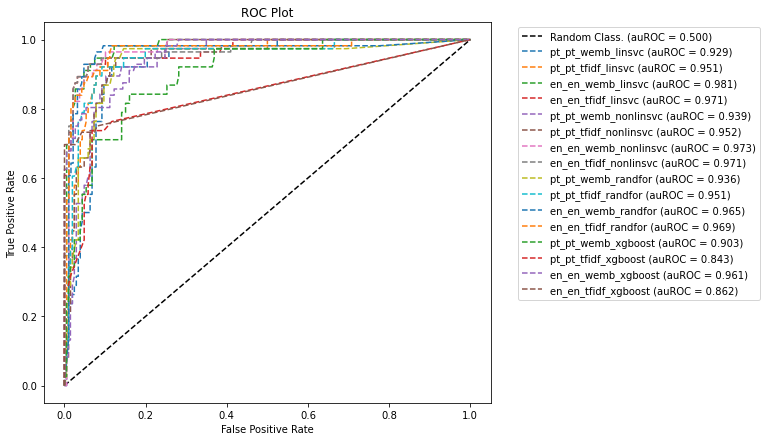

In [ ]:
plt.subplots(figsize=(8,7))
plt.plot(RAND_fpr, RAND_tpr, linestyle   = '--', color='k', label='Random Class. (auROC = %0.3f)' % RAND_auc)
plt.plot(pt_pt_wemb_linsvc_fpr, pt_pt_wemb_linsvc_tpr, linestyle   = '--', label='pt_pt_wemb_linsvc (auROC = %0.3f)' % pt_pt_wemb_linsvc_auc)
plt.plot(pt_pt_tfidf_linsvc_fpr, pt_pt_tfidf_linsvc_tpr, linestyle   = '--', label='pt_pt_tfidf_linsvc (auROC = %0.3f)' % pt_pt_tfidf_linsvc_auc)
plt.plot(en_en_wemb_linsvc_fpr, en_en_wemb_linsvc_tpr, linestyle   = '--', label='en_en_wemb_linsvc (auROC = %0.3f)' % en_en_wemb_linsvc_auc)
plt.plot(en_en_tfidf_linsvc_fpr, en_en_tfidf_linsvc_tpr, linestyle   = '--', label='en_en_tfidf_linsvc (auROC = %0.3f)' % en_en_tfidf_linsvc_auc)

plt.plot(pt_pt_wemb_nonlinsvc_fpr, pt_pt_wemb_nonlinsvc_tpr, linestyle   = '--', label='pt_pt_wemb_nonlinsvc (auROC = %0.3f)' % pt_pt_wemb_nonlinsvc_auc)
plt.plot(pt_pt_tfidf_nonlinsvc_fpr, pt_pt_tfidf_nonlinsvc_tpr, linestyle   = '--', label='pt_pt_tfidf_nonlinsvc (auROC = %0.3f)' % pt_pt_tfidf_nonlinsvc_auc)
plt.plot(en_en_wemb_nonlinsvc_fpr, en_en_wemb_nonlinsvc_tpr, linestyle   = '--', label='en_en_wemb_nonlinsvc (auROC = %0.3f)' % en_en_wemb_nonlinsvc_auc)
plt.plot(en_en_tfidf_nonlinsvc_fpr, en_en_tfidf_nonlinsvc_tpr, linestyle   = '--', label='en_en_tfidf_nonlinsvc (auROC = %0.3f)' % en_en_tfidf_nonlinsvc_auc)

plt.plot(pt_pt_wemb_randfor_fpr, pt_pt_wemb_randfor_tpr, linestyle   = '--', label='pt_pt_wemb_randfor (auROC = %0.3f)' % pt_pt_wemb_randfor_auc)
plt.plot(pt_pt_tfidf_randfor_fpr, pt_pt_tfidf_randfor_tpr, linestyle   = '--', label='pt_pt_tfidf_randfor (auROC = %0.3f)' % pt_pt_tfidf_randfor_auc)
plt.plot(en_en_wemb_randfor_fpr, en_en_wemb_randfor_tpr, linestyle   = '--', label='en_en_wemb_randfor (auROC = %0.3f)' % en_en_wemb_randfor_auc)
plt.plot(en_en_tfidf_randfor_fpr, en_en_tfidf_randfor_tpr, linestyle   = '--', label='en_en_tfidf_randfor (auROC = %0.3f)' % en_en_tfidf_randfor_auc)

plt.plot(pt_pt_wemb_xgboost_fpr, pt_pt_wemb_xgboost_tpr, linestyle   = '--', label='pt_pt_wemb_xgboost (auROC = %0.3f)' % pt_pt_wemb_xgboost_auc)
plt.plot(pt_pt_tfidf_xgboost_fpr, pt_pt_tfidf_xgboost_tpr, linestyle   = '--', label='pt_pt_tfidf_xgboost (auROC = %0.3f)' % pt_pt_tfidf_xgboost_auc)
plt.plot(en_en_wemb_xgboost_fpr, en_en_wemb_xgboost_tpr, linestyle   = '--', label='en_en_wemb_xgboost (auROC = %0.3f)' % en_en_wemb_xgboost_auc)
plt.plot(en_en_tfidf_xgboost_fpr, en_en_tfidf_xgboost_tpr, linestyle   = '--', label='en_en_tfidf_xgboost (auROC = %0.3f)' % en_en_tfidf_xgboost_auc)


# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
#plt.legend() # 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Show plot
plt.show()

**Non-Linear SVM applied to word embedding numerical vectors obtained from translated descriptions submited to 'english NLP pipeline'** is also the best result considering AUC criteria.

# Final coments
This project presents a full scope solution to solve poorly categorized products, a very common issue present even on big deal e-commerces, such as Amazon.

We started from web scraping product descriptions directly from Amazon's Brazilian e-commerce and, after applying NLP techniques to both treat corpus and create numerical representations for descriptions, we applied several ML models to define the best approach.

Turns out that translated descriptions from portuguese to english presented better results in almost every model. This reflects how much Portuguese NLP needs to improve. The best model was Non-Linear SVM. This is no surprise since SVM usually deals well with high dimension problems. Regarding vectorization methods, word embeddings and Tf-idf produced close results. Finally, the best combination of it all was **Non-Linear SVM applied to word embedding numerical vectors obtained from translated descriptions submited to 'english NLP pipeline'**